In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Reprojecting

## Read in data 

In [2]:
# Import countries shapefile
fp = os.path.join('data','ne_50m_admin_0_countries','ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)
communities

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)
3,Vec-Liepāja,85260,LV,454432,POINT (21.01667 56.53333)
4,Tukums,18348,LV,454768,POINT (23.15528 56.96694)
...,...,...,...,...,...
1419,Centralniy,214625,RU,8504960,POINT (30.36072 59.93111)
1420,Svetlanovskiy,85508,RU,8504964,POINT (30.33051 60.00276)
1421,Sampsonievskiy,39318,RU,8504965,POINT (30.34295 59.98499)
1422,Vostochnoe Degunino,95000,RU,8505053,POINT (37.55758 55.88010)


In [4]:
# Import country names from URL
URL = 'https://raw.githubusercontent.com/MEDS-eds-220/MEDS-eds-220-course/refs/heads/main/book/chapters/lesson-12-merge-data/country_names.csv'
country_names = pd.read_csv(URL)
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


The CRS of the `communities` geodataframe is EPSG:4326 because all GeoJSON files are given in this crs. 

In [5]:
communities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
countries.crs == communities.crs

True

Since the CRSs are a match, we can plot them together

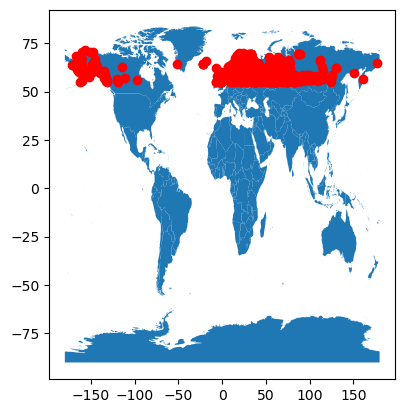

In [8]:
fig, ax = plt.subplots()
countries.plot(ax = ax)
communities.plot(ax = ax, color = "red")
plt.show()

## Arctic communities by country

In [9]:
# Number of Arctic communities by country
n_comms = (communities.groupby('country')
                        .size()
                        .reset_index(name = 'n_communities'))

n_comms

,country,n_communities
0,AX,1
1,BY,8
2,CA,7
3,DK,72
4,EE,14
5,FI,98
6,FO,1
7,GB,96
8,GL,1
9,IS,5


## `if-else` statements

Our goal is to merge the `n_comms` per country with the `countries` geometries: to merge them , we want to have at least one column in common

In [10]:
# Check for intersection between the two dataframes 
set(countries.columns).intersection(n_comms.columns)

set()

In [11]:
common_columns = set(countries.columns).intersection(n_comms.columns)

# Check if there are any common columns
if len(common_columns) != 0:
    print(f"Common columns:{common_columns}")
else:
    print("No columns in common")


No columns in common


## Check-in 

Wrap up the previous code into a function called `check_common_columns` that prints a message depending on whether two general dataframes have column names in common

In [12]:
def check_common_columns(df1, df2):
    """
    Prints a message depending on whether two pandas.Dataframes have columns in common.
    """
    common_columns = set(df1.columns).intersection(df2.columns)

    # Check if there are any common columns
    if len(common_columns) != 0:
        print(f"Common columns:{common_columns}")
    else:
        print("No columns in common")

In [13]:
check_common_columns(countries, n_comms)

No columns in common


## Merging data frames

We want to:
1. use the `country_names` data frame to add the country names to the `n_comms` data.
2. Merge the resulting data frame with `country_names`

To merge dataframes we can use `pandas.merge()` function:
```python
output_df = pd.merge(left_df,               # df on the left side
                    right_df,               # df on the right side
                    how = type_of_join,     # type of join, default = inner join
                    on = column_to_join)    # which column to join on, must be in both dataframes

In [14]:
n_comms = pd.merge(n_comms,
                   country_names,
                   how = 'left',
                   on = 'country')

n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [15]:
check_common_columns(n_comms, countries)

Common columns:{'admin'}


## Check-ins

Create a new variable called `arctic_countries` which is the result of an inner join between our `countries` and `n_comms` dataframes. 

In [16]:
arctic_countries = pd.merge(countries,
                            n_comms,
                            how = 'inner', # Kepp rows with matches in both dataframes
                            on = 'admin')

arctic_countries

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
3,Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
4,Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48
5,Lithuania,Sovereign country,"MULTIPOLYGON (((20.95781 55.27891, 20.89980 55...",LT,26
6,Latvia,Sovereign country,"POLYGON ((26.59355 55.66753, 26.54287 55.67241...",LV,25
7,Iceland,Sovereign country,"POLYGON ((-15.54312 66.22852, -15.42847 66.224...",IS,5
8,Finland,Country,"MULTIPOLYGON (((24.15547 65.80527, 24.04902 65...",FI,98
9,Estonia,Sovereign country,"MULTIPOLYGON (((27.35195 57.52812, 27.32656 57...",EE,14


Checking the resulting data we notice we lost the Aland Islands. Let's double check

In [17]:
# Update index
arctic_countries = arctic_countries.set_index('admin')
arctic_countries.head()

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133
Russia,Sovereign country,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ...",RU,774
Norway,Sovereign country,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69...",NO,48


In [18]:
# Check Aland islands is nowhere in the dataframe
'Aland Islands' in arctic_countries.values

False

The Alan Islands is an autonomous region in Finland and there is one Arctic community regestered in this region. We will directly add one to Finland to account for this.


In [19]:
arctic_countries.at['Finland', 'n_communities']

98

In [20]:
arctic_countries.at['Finland', 'n_communities'] += 1

In [21]:
arctic_countries.at['Finland', 'n_communities']

99

## Choropleth map 

To make the map we just need to specify the `column` parameter in `plot()` and make it equal to the column with the values we want to plot in each country:


<Axes: >

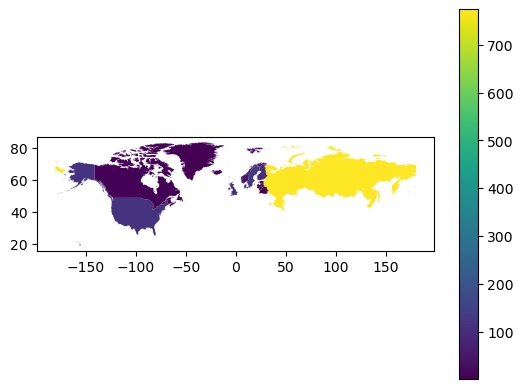

In [23]:
arctic_countries.plot(column = 'n_communities',
                      legend = True)

## Reprojecting

`to_crs()` Method for  `geopandas.GeoDataFrame`s

```python
updated_geodf = geodf.to_crs(new_crs)
```

here `new_crs` is the CRS we want to convert to, this is an object of type CRS or a string representing the CRS

In [26]:
arctic_countries = arctic_countries.to_crs('epsg:3413')

<Axes: >

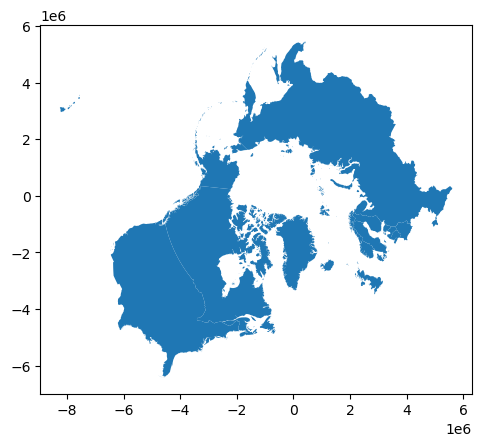

In [27]:
arctic_countries.plot()

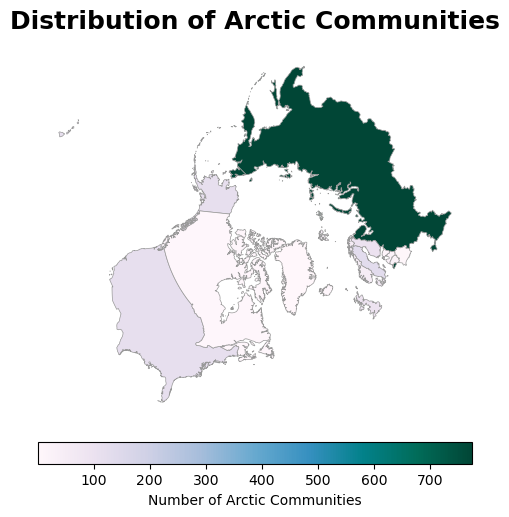

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the axis for a cleaner map
ax.axis('off')

# Create choropleth map of communities
# Plot with refined color and edge style
arctic_countries.plot(
    ax=ax,
    column='n_communities',
    cmap='PuBuGn',
    legend=True,
    edgecolor="0.6",
    linewidth=0.5,
    legend_kwds={
        "shrink": 0.7,
        "label": "Number of Arctic Communities",
        "orientation": "horizontal", # change orientation
        "pad": 0.05
    }
)

# Add title and subtitle for better context
ax.set_title('Distribution of Arctic Communities', fontsize=18, weight='bold', pad=15)

plt.show()